In [ ]:
import os, time
import numpy as np
import pickle

# Figures 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import style
from fig_specs import *
save_fig=True

# Data directory
from data_dir import data_dir

# Construct data file names
# Full file names look like:
# For flipflop task with input, recurrent, output weights trained; network size N = 128; learning rate 0.05:
# "flipflop_dim_recs_gs_adam_train_wi_wrec_wo_N_128_lr0_005.pkl"
tasks_name = ["flipflop", "mante", "romo"]
file_name_pre = "_dim_recs_gs_adam_train_wi_wrec_wo_N_"
file_name_post = "_lr0_005"
# Network sizes
dim_recs = np.array([64, 128, 256, 512, 1024])

In [2]:
n_tasks = len(tasks_name)
n_d = len(dim_recs)
# Results
res_ds = []
for idx_task in range(n_tasks):

    task_name = tasks_name[idx_task]

    # Obtain shared parameters
    data_file_name = task_name + file_name_pre + "%d"%dim_recs[0] + file_name_post
    data_file_name += ".pkl"
    data_file = os.path.join(data_dir, data_file_name)
    with open(data_file, 'rb') as handle:
        res_dict = pickle.load(handle)
    print("Loaded data from " + data_file)
    dt = res_dict["dt"]
    gs = res_dict["gs"]
    lr = res_dict["lr"]
    noise_std = res_dict["noise_std"]
    n_epochs = res_dict["n_epochs"]
    rec_step = res_dict["rec_step"]
    epochs = res_dict["epochs"]
    rec_epochs = res_dict["rec_epochs"]
    ranks = res_dict["ranks"]
    losses_all = res_dict["losses_all"]
    n_samples, n_gs = losses_all.shape[:2]
    rank_max = ranks[-1] + 1
    n_ranks = len(ranks)

    # Define arrays for results
    losses_d = np.zeros((n_d, n_samples, n_gs, n_epochs))
    loss_rr_d = np.zeros((n_d, n_samples, n_gs, n_ranks))
    sv_d = np.zeros((n_d, 3, n_samples, n_gs, n_ranks-1))
    norm_d = np.zeros((n_d, 3, n_samples, n_gs))

    for idx_d, dim_rec in enumerate(dim_recs):
        # Obtain shared parameters
        data_file_name = task_name + file_name_pre + "%d"%dim_rec + file_name_post
        data_file_name += ".pkl"
        data_file = os.path.join(data_dir, data_file_name)
        if os.path.isfile(data_file):
            with open(data_file, 'rb') as handle:
                res_dict = pickle.load(handle)
            print("Loaded data from " + data_file)
            losses_all = res_dict["losses_all"]
            grad_norms_all = res_dict["grad_norms_all"]
            sv_dw_all = res_dict["sv_dw_all"]
            loss_rr_all = res_dict["loss_rr_all"]
            loss_shuff_all = res_dict["loss_shuff_all"]
            sv_all = res_dict["sv_all"]
            
            losses_d[idx_d] = losses_all
            loss_rr_d[idx_d] = loss_rr_all
            sv_d[idx_d, :] = sv_all[:, :, :, :n_ranks-1]
            norm_d[idx_d, :] = np.sqrt(np.sum(sv_all**2, axis=-1))
            
    del res_dict
    res_d = [epochs, ranks, losses_d, loss_rr_d, sv_d, norm_d]
    res_ds.append(res_d)

Loaded data from ..\..\data\neurips_2020\flipflop_dim_recs_gs_adam_train_wi_wrec_wo_N_64_lr0_005.pkl
Loaded data from ..\..\data\neurips_2020\flipflop_dim_recs_gs_adam_train_wi_wrec_wo_N_64_lr0_005.pkl
Loaded data from ..\..\data\neurips_2020\flipflop_dim_recs_gs_adam_train_wi_wrec_wo_N_128_lr0_005.pkl
Loaded data from ..\..\data\neurips_2020\flipflop_dim_recs_gs_adam_train_wi_wrec_wo_N_256_lr0_005.pkl
Loaded data from ..\..\data\neurips_2020\flipflop_dim_recs_gs_adam_train_wi_wrec_wo_N_512_lr0_005.pkl
Loaded data from ..\..\data\neurips_2020\flipflop_dim_recs_gs_adam_train_wi_wrec_wo_N_1024_lr0_005.pkl
Loaded data from ..\..\data\neurips_2020\mante_dim_recs_gs_adam_train_wi_wrec_wo_N_64_lr0_005.pkl
Loaded data from ..\..\data\neurips_2020\mante_dim_recs_gs_adam_train_wi_wrec_wo_N_64_lr0_005.pkl
Loaded data from ..\..\data\neurips_2020\mante_dim_recs_gs_adam_train_wi_wrec_wo_N_128_lr0_005.pkl
Loaded data from ..\..\data\neurips_2020\mante_dim_recs_gs_adam_train_wi_wrec_wo_N_256_lr0_005

Save figure to ../../tex/neurips_2020/submission_2/figures\norms_dim_recs.pdf
Save figure to ../../tex/neurips_2020/submission_2/figures\norms_dim_recs.png


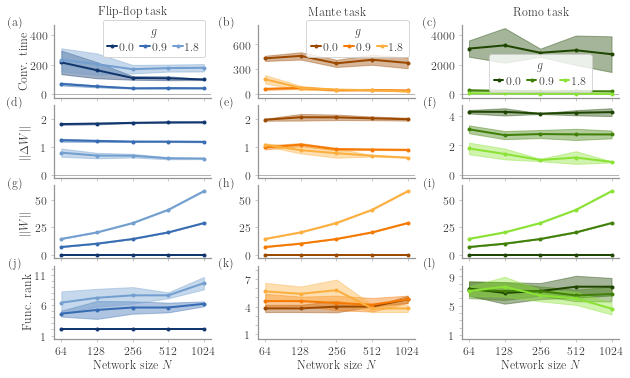

In [5]:
# Training times and minimal rank
fig = plt.figure(figsize=(fig_width, 0.9 * fig_height))
gs0 = GridSpec(4, n_tasks)
gs0.update(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0.3, hspace=0.1)
axes_all = np.array([[plt.subplot(gs0[i, j]) for j in range(n_tasks)] for i in range(4)])
ms = 3
min_num_samples_for_avg = 3

gs_lbl = ["%.1f" % g for g in gs]

for idx_task in range(n_tasks):
    axes = axes_all[:, idx_task]
    ax0, ax1, ax2, ax3 = axes
    epochs, ranks, losses_d, loss_rr_d, sv_d, norm_d = res_ds[idx_task]
    
    for i, g in enumerate(gs):
        c = cs[idx_task, i]
        
        # Norms
        norm_w = norm_d[:, 0, :, i]
        norm_dw = norm_d[:, 2, :, i]
        
        # Learning time
        losses = losses_d[:, :, i]
        loss_0 = losses[:, :, 0]
        loss_c = rel_loss_c * loss_0
        idxs_c = np.argmax(losses < loss_c[:, :, None], axis=-1)
        epochs_c = epochs[idxs_c]

        # Minimal rank
        loss_rr = loss_rr_d[:, :, i]
        loss_0 = loss_rr[:, :, 0]
        loss_c = rel_loss_c * loss_0
        idxs_c = np.argmax(loss_rr < loss_c[:, :, None], axis=-1)
        ranks_c = ranks[idxs_c]

        # Mask
        mask_mr = ranks_c > 0
        mask_lt = epochs_c > 0
        mask = mask_lt * mask_mr

        # Compute mean and std
        ranks_c_m, ranks_c_s = np.zeros((2, n_d))
        epochs_c_m, epochs_c_s = np.zeros((2, n_d))
        norm_dw_m, norm_dw_s = np.zeros((2, n_d))
        norm_w_m, norm_w_s = np.zeros((2, n_d))
        mask_3 = np.zeros((n_d), dtype=bool)
        for j in range(n_d):
            if mask[j].sum() >= min_num_samples_for_avg:
                ranks_c_m[j] = ranks_c[j][mask[j]].mean()
                ranks_c_s[j] = ranks_c[j][mask[j]].std()
                epochs_c_m[j] = epochs_c[j][mask[j]].mean()
                epochs_c_s[j] = epochs_c[j][mask[j]].std()
                norm_dw_m[j] = norm_dw[j][mask[j]].mean()
                norm_dw_s[j] = norm_dw[j][mask[j]].std()
                norm_w_m[j] = norm_w[j][mask[j]].mean()
                norm_w_s[j] = norm_w[j][mask[j]].std()
                mask_3[j] = True

        # Plot
        drps = np.int_(np.log(dim_recs) / np.log(2))
        
        ax0.plot(drps[mask_3], epochs_c_m[mask_3], 'o-', lw=lw, ms=ms, c=c, label=gs_lbl[i])
        ax1.plot(drps[mask_3], norm_dw_m[mask_3], 'o-', lw=lw, ms=ms, c=c, label=gs_lbl[i])
        ax2.plot(drps[mask_3], norm_w_m[mask_3], 'o-', lw=lw, ms=ms, c=c, label=gs_lbl[i])
        ax3.plot(drps[mask_3], ranks_c_m[mask_3], 'o-', lw=lw, ms=ms, c=c, label=gs_lbl[i])
        # Std 
        alpha=0.4
        ax0.fill_between(drps[mask_3], epochs_c_m[mask_3] - epochs_c_s[mask_3], epochs_c_m[mask_3] + epochs_c_s[mask_3], 
                         color=c, alpha=alpha)
        ax1.fill_between(drps[mask_3], norm_dw_m[mask_3] - norm_dw_s[mask_3], norm_dw_m[mask_3] + norm_dw_s[mask_3], 
                         color=c, alpha=alpha)
        ax2.fill_between(drps[mask_3], norm_w_m[mask_3] - norm_w_s[mask_3], norm_w_m[mask_3] + norm_w_s[mask_3], 
                         color=c, alpha=alpha)
        ax3.fill_between(drps[mask_3], ranks_c_m[mask_3] - ranks_c_s[mask_3], ranks_c_m[mask_3] + ranks_c_s[mask_3], 
                         color=c, alpha=alpha)
        
        
    ########################################################
    ax0.axhline(0, ls='-', c='0.7', zorder=-1)
    ymax = [450, 800, 4500][idx_task]
    ymaxt = [400, 600, 4000][idx_task]
    ax0.set_yticks([0, ymaxt//2, ymaxt])
    ax0.set_ylim(-ymax * 0.05, ymax * 1.05)

    ax1.axhline(0, ls='-', c='0.7', zorder=-1)
    if not idx_task == (n_tasks-1):
        ax1.set_yticks([0, 1, 2])
        ax1.set_ylim([-0.1, 2.5])
        
    ymax = 60
    ax2.set_ylim([-0.05 * ymax, ymax*1.05])

    if idx_task == 0:
        ax0.set_ylabel(r"Conv. time", labelpad=0)
        ax1.set_ylabel("$||\Delta W||$", labelpad=10)
        ax2.set_ylabel("$||W||$", labelpad=4)
        ax3.set_ylabel(r"Func. rank", labelpad=2)
    for i, ax in enumerate(axes):
        ax.set_xticks(drps)
        xticklabels = dim_recs
        if i == 3:
            ax.set_xticklabels(xticklabels)
            ax.set_xlabel("Network size $N$")
        else:
            ax.set_xticklabels([])
        
    # Legend
    loc = [1, 1, 8][idx_task]
    leg = ax0.legend(loc=loc, ncol=3, labelspacing=0.2, handlelength=0.8, markerscale=1, columnspacing=0.5, handletextpad=0.2, 
               title="$g$", title_fontsize=fs,)
    # Move legend down/up
    if not idx_task == (n_tasks-1):
        ax_leg = ax0
        bb = leg.get_bbox_to_anchor().inverse_transformed(ax_leg.transAxes)
        xOffset = 0.
        bb.x0 += xOffset
        bb.x1 += xOffset
        yOffset = 0.15
        bb.y0 += yOffset
        bb.y1 += yOffset
        leg.set_bbox_to_anchor(bb, transform = ax_leg.transAxes)

# Label plots
ypos = 0.95
for i in range(4 * n_tasks):
    if i%3 == 0:
        xpos = -0.25
    elif i%3 == 1:
        xpos = -0.2
    else:
        xpos = -0.2
    ax = fig.axes[i]
    ax.text(xpos, ypos, flbs[i], fontsize=fs, ha='center', va='bottom', transform=ax.transAxes)
    
tasks_lbl = ["Flip-flop", "Mante", "Romo"]
for i in range(3):
    ax = fig.axes[i]
    ax.set_title(tasks_lbl[i] + "  task", pad=10)

style.fixticks(fig)

for idx_task in range(n_tasks):
    axes = axes_all[:, idx_task]
    ax0, ax1, ax2, ax3 = axes
    # Ticks
    min_rank = 1
    max_rank = [12, 8, 10][idx_task]
    yticks = np.arange(min_rank, max_rank + 1)
    ax3.set_yticks(yticks)
    yticklabels = []
    for i in yticks:
        if i in [1, max_rank//2, max_rank-1]:
            yticklabels.append(i)
        else:
            yticklabels.append("")
    ax3.set_yticklabels(yticklabels)
    ax3.set_ylim(min_rank-0.5, max_rank+0.5)

fig_name = "norms_dim_recs"
if save_fig:
    style.saving_fig(fig, figure_path, fig_name, 'pdf')
    style.saving_fig(fig, figure_path, fig_name, 'png')
plt.show(fig)
plt.close(fig)